In [1]:
# load packages
import os
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import os
import random
import datetime
import statsmodels as sm
import sklearn
import sklearn.preprocessing
import sklearn.metrics
import time

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

plt.style.use('ggplot')
import matplotlib.dates as mdates
import matplotlib.ticker as mtick



In [2]:
# Import Darts and its components
# Darts is a Python library for easy manipulation and forecasting of time series.
# It provides a wide range of models, utilities, and tools for time series analysis.
import darts
from darts import TimeSeries
from darts.utils.utils import generate_index
from darts.metrics import mape, smape, mae, mse, rmse


from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.utils import ModelMode

# import the baseline models
from darts.models import NaiveSeasonal, NaiveMean, ExponentialSmoothing, NaiveMovingAverage, NaiveDrift
# import the statistical models
from darts.models import ARIMA, VARIMA, StatsForecastModel
from darts.models import AutoMFLES, AutoCES, AutoTheta, AutoTBATS, AutoCES, AutoCES, AutoARIMA, Croston
from darts.models import KalmanForecaster, FourTheta, FFT
# import the machine learning models
from darts.models import LightGBMModel, XGBModel, RandomForest, Prophet
# import the deep learning models
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, TFTModel
from darts.models import KalmanFilter
from darts.utils import timeseries_generation as tg

In [3]:
import torch
if torch.backends.mps.is_available():
    torch.set_default_device('cpu')

# Set the default device for PyTorch to CPU
#import torch
#torch.set_default_device('cpu')

In [4]:
# change the working directory to the download directory
os.chdir(os.path.expanduser('~/Downloads/m5-forecasting-accuracy'))
# print the current working directory
print(os.getcwd())

/Users/jimhoover/Downloads/m5-forecasting-accuracy


In [5]:
# read in the CSV file from the M5 competition (30,490 SKUs )
largefile = pd.read_csv('sales_train_evaluation.csv')
# largefile


In [6]:
# read in the CSV file with the calendar data and the holiday information
calendar_long = pd.read_csv('calendar.csv')
# calendar_long


In [7]:
# select a single SKU
single_sku = largefile.loc[largefile.index == 9057]
single_sku

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
9057,FOODS_3_737_CA_3_evaluation,FOODS_3_737,FOODS_3,FOODS,CA_3,CA,0,0,0,0,...,0,0,0,0,0,1,0,1,0,3


In [8]:
# transpose the data frame
single_sku = single_sku.transpose()
single_sku = single_sku.reset_index()
single_sku

,index,9057
0,id,FOODS_3_737_CA_3_evaluation
1,item_id,FOODS_3_737
2,dept_id,FOODS_3
3,cat_id,FOODS
4,store_id,CA_3
...,...,...
1942,d_1937,1
1943,d_1938,0
1944,d_1939,1
1945,d_1940,0


In [9]:
# save the description information rows
single_sku_description = single_sku.iloc[0:6, :]
single_sku_description

,index,9057
0,id,FOODS_3_737_CA_3_evaluation
1,item_id,FOODS_3_737
2,dept_id,FOODS_3
3,cat_id,FOODS
4,store_id,CA_3
5,state_id,CA


In [10]:
# just save the demand rows in the datafram
single_sku.drop(index=[*range(0,6,1)], axis = 1, inplace= True)
single_sku
single_sku.columns = ['Day', 'Demand']
single_sku = single_sku.reset_index(drop=True)
single_sku

,Day,Demand
0,d_1,0
1,d_2,0
2,d_3,0
3,d_4,0
4,d_5,0
...,...,...
1936,d_1937,1
1937,d_1938,0
1938,d_1939,1
1939,d_1940,0


In [11]:
# set up the dates for the data in the data frame
num_days = len(single_sku)
start_date = datetime.datetime(2011, 1, 29)
dates = [start_date + datetime.timedelta(days=idx) for idx in range(num_days)]
single_sku['date'] = dates
single_sku

,Day,Demand,date
0,d_1,0,2011-01-29
1,d_2,0,2011-01-30
2,d_3,0,2011-01-31
3,d_4,0,2011-02-01
4,d_5,0,2011-02-02
...,...,...,...
1936,d_1937,1,2016-05-18
1937,d_1938,0,2016-05-19
1938,d_1939,1,2016-05-20
1939,d_1940,0,2016-05-21


In [12]:
# convert the date column to a datetime object
single_sku['date'] = pd.to_datetime(single_sku['date'])
calendar_long['date'] = pd.to_datetime(calendar_long['date'])

In [13]:
# merge the single SKU data with the calendar data
# using the date column as the key
# and using a left join to keep all dates in the single SKU data
# and add the calendar information to the single SKU data
merged = single_sku.merge(calendar_long, on='date', how='left', indicator = False)
# remove the d column from the merged data frame (it is a duplicate of the Day column)
merged.drop(columns=['d'], inplace=True)
merged

,Day,Demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,0,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,0,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,0,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,d_1937,1,2016-05-18,11616,Wednesday,5,5,2016,NaN,NaN,NaN,NaN,0,0,0
1937,d_1938,0,2016-05-19,11616,Thursday,6,5,2016,NaN,NaN,NaN,NaN,0,0,0
1938,d_1939,1,2016-05-20,11616,Friday,7,5,2016,NaN,NaN,NaN,NaN,0,0,0
1939,d_1940,0,2016-05-21,11617,Saturday,1,5,2016,NaN,NaN,NaN,NaN,0,0,0


In [14]:
# save the merged data frame to an Excel file
merged.to_excel('single_sku.xlsx', index=False)

The single_sku file will be used for the forecasting efforts. It is relatively straightforward to replace this SKU with another SKU from the file.

In [15]:
# read in the single SKU data from the Excel file
df = pd.read_excel('single_sku.xlsx')
df

,Day,Demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,0,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,0,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,0,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,0,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,d_1937,1,2016-05-18,11616,Wednesday,5,5,2016,NaN,NaN,NaN,NaN,0,0,0
1937,d_1938,0,2016-05-19,11616,Thursday,6,5,2016,NaN,NaN,NaN,NaN,0,0,0
1938,d_1939,1,2016-05-20,11616,Friday,7,5,2016,NaN,NaN,NaN,NaN,0,0,0
1939,d_1940,0,2016-05-21,11617,Saturday,1,5,2016,NaN,NaN,NaN,NaN,0,0,0


The next section sets up a data frame for recording forecasts used for calculating evaluation metrics. Then, as each forecasting method is used, the outcomes can be evaluated and visualized.

In [16]:
# set up an evaluation data frame with the date field and the Demand field for the last 30 days of demand for the SKU
evaluation_df = df[['date', 'Demand']].tail(30)


The following code establishes functions for evaluation of forecasts over the forecast horizon.

In [17]:
# from Ruiying's code
# Set numpy print options to avoid scientific notation
np.set_printoptions(suppress=True)
def evaluate_model(y_true, y_pred):
    mae = round(np.mean(np.abs(y_true - y_pred)),2)
    mse = round(np.mean((y_true - y_pred) ** 2),2)
    rmse = round(np.sqrt(mse),2)
    # Handle MAPE by avoiding division by zero or very small values
    epsilon = 1e-10  # A small constant to avoid division by zero
    y_true_safe = np.where(y_true == 0, epsilon, y_true)  # Replace zeros in y_true with epsilon
    mape = round(np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100,2)
    smape = round(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)) * 2) * 100,2)
    cumulative_bias = round(np.sum(y_true - y_pred),2)

    # Other bias-related metrics
    mean_bias_deviation = round(np.mean(y_true - y_pred),2)
    mean_percentage_bias = round(np.mean((y_true_safe - y_pred) / y_true_safe) * 100,2)
    cumulative_relative_error = round(np.sum((y_true_safe - y_pred) / y_true_safe)*100,2)

    # calculate the training time
    training_time = time.time() - start_time

    return mae, mse, rmse, mape, smape, cumulative_bias, mean_bias_deviation, mean_percentage_bias, cumulative_relative_error, training_time


In [18]:
# we will use Darts to create a TimeSeries object for the evaluation data
evaluation_series = TimeSeries.from_dataframe(df, time_col='date', value_cols='Demand')
train, val = evaluation_series[:-30], evaluation_series[-30:]

In [19]:
# apply the true naive forecasting model
# the last value in the training set is used as the forecast for all future values
# capture the training time for this model
start_time = time.time()

last_value = train.values()[-1]
naive_forecast = TimeSeries.from_times_and_values(
    times=val.time_index,
    values=np.full(len(val), last_value)
)
# capture the training time
training_time = time.time() - start_time
# save the forecasts to the evaluation data frame
evaluation_df['Naive'] = np.round(naive_forecast.values(), 2)
# evaluate the naive forecast
naive_forecast_metrics = evaluate_model(val.values(), naive_forecast.values())


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/858079771.py:12: RuntimeWarning: invalid value encountered in divide


In [20]:
evaluation_df

,date,Demand,Naive
1911,2016-04-23,0,0.0
1912,2016-04-24,1,0.0
1913,2016-04-25,0,0.0
1914,2016-04-26,0,0.0
1915,2016-04-27,0,0.0
1916,2016-04-28,0,0.0
1917,2016-04-29,0,0.0
1918,2016-04-30,2,0.0
1919,2016-05-01,1,0.0
1920,2016-05-02,1,0.0


In [21]:
# evaluate the Naive model
# calculate the training time for the Naive model
print("Naive Forecast Metrics:")
print(f"MAE: {naive_forecast_metrics[0]}, MSE: {naive_forecast_metrics[1]}, RMSE: {naive_forecast_metrics[2]}, "
      f"MAPE: {naive_forecast_metrics[3]}, SMAPE: {naive_forecast_metrics[4]}, "
      f"Cumulative Bias: {naive_forecast_metrics[5]}, "
      f"Mean Bias Deviation: {naive_forecast_metrics[6]}, Mean Percentage Bias: {naive_forecast_metrics[7]}, "
      f"Cumulative Relative Error: {naive_forecast_metrics[8]}, "
      f"Training Time (s): {naive_forecast_metrics[9]}")


Naive Forecast Metrics:
MAE: 0.37, MSE: 0.63, RMSE: 0.79, MAPE: 26.67, SMAPE: nan, Cumulative Bias: 11.0, Mean Bias Deviation: 0.37, Mean Percentage Bias: 100.0, Cumulative Relative Error: 3000.0, Training Time (s): 0.0023207664489746094


In [22]:
# save the evaluation metrics to a new data frame with the model name as the column name

metrics_df = pd.DataFrame({
    'Model': ['Naive'],
    'MAE': [naive_forecast_metrics[0]],
    'MSE': [naive_forecast_metrics[1]],
    'RMSE': [naive_forecast_metrics[2]],
    'MAPE': [naive_forecast_metrics[3]],
    'SMAPE': [naive_forecast_metrics[4]],
    'Cumulative Bias': [naive_forecast_metrics[5]],
    'Mean Bias Deviation': [naive_forecast_metrics[6]],
    'Mean Percentage Bias': [naive_forecast_metrics[7]],
    'Cumulative Relative Error': [naive_forecast_metrics[8]],
    'Training Time (s)': [naive_forecast_metrics[9]]
})

In [23]:
metrics_df

,Model,MAE,MSE,RMSE,MAPE,SMAPE,Cumulative Bias,Mean Bias Deviation,Mean Percentage Bias,Cumulative Relative Error,Training Time (s)
0,Naive,0.37,0.63,0.79,26.67,NaN,11.0,0.37,100.0,3000.0,0.002321


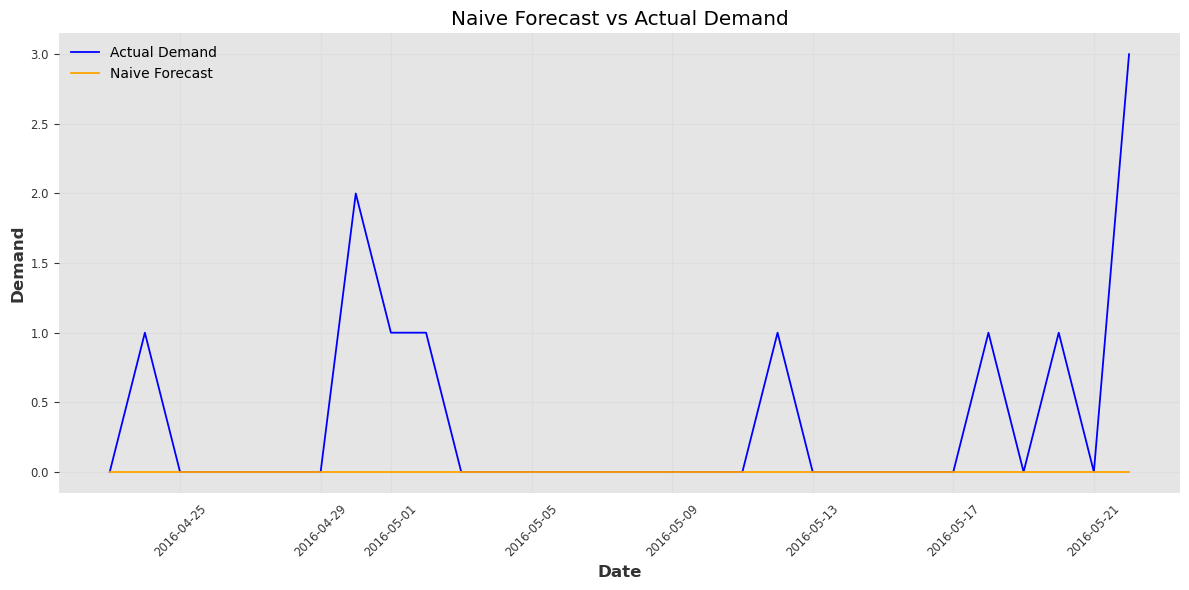

In [24]:
# plot the actual vs predicted values for the Naive model
plt.figure(figsize=(12, 6))
plt.plot(val.time_index, val.values(), label='Actual Demand', color='blue')
plt.plot(val.time_index, naive_forecast.values(), label='Naive Forecast', color='orange')
plt.title('Naive Forecast vs Actual Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The next section will run some simple time series models from DARTS and record the results.

In [25]:
# Define simple models to evaluate
def get_simple_darts_models():
    return {
        "NaiveMean": NaiveMean(),
        "NaiveSeasonal": NaiveSeasonal(K=7),  # Weekly seasonality
        "NaiveMovingAverage": NaiveMovingAverage(),  #
        "NaiveDrift": NaiveDrift(),
        "ExponentialSmoothing": ExponentialSmoothing(),
    }

In [26]:
# Evaluate models
def evaluate_models(models_dict, series, val_series, forecast_horizon=30):
    results = []
    for name, model in models_dict.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(series)
        forecast = model.predict(forecast_horizon)
        training_time = time.time() - start_time
        model_mae = mae(val_series, forecast)
        model_bias = float((val_series - forecast).sum().values()[0])
        results.append({
            "Model": name,
            "MAE": model_mae,
            "Bias": model_bias,
            "Training Time (s)": training_time,
            "Forecast": forecast
        })
    return results

In [27]:
# Convert results to DataFrame
def results_to_df(results):
    return pd.DataFrame([
        {
            "Model": r["Model"],
            "MAE": r["MAE"],
            "Bias": r["Bias"],
            "Training Time (s)": r["Training Time (s)"]
        } for r in results
    ])

In [28]:
# return forecasts to the evaluation DataFrame
def add_forecasts_to_df(evaluation_df, results):
    for result in results:
        model_name = result["Model"]
        forecast_values = result["Forecast"].values()
        evaluation_df[model_name] = np.round(forecast_values, 2)
    return evaluation_df

In [29]:
# latest try
# append new model metrics to the metrics_df using the evaluation_df columns
def add_results_to_metrics_df(evaluation_df, metrics_df, results_df):
    # Get the prediction columns excluding 'date', 'Demand', and previous models
    # only include the new model not currently in the metrics_df
    all_forecast_columns = [col for col in evaluation_df.columns if col not in ['date', 'Demand']]
    already_recorded_models = metrics_df['Model'].unique()
    new_forecasts = [col for col in all_forecast_columns if col not in already_recorded_models]
    
    # 

    for model_name in new_forecasts:
        y_true = evaluation_df['Demand'].values
        y_pred = evaluation_df[model_name].values
        epsilon = 0.01
        y_true_safe = np.where(y_true == 0, epsilon, y_true)

        new_row = {
            'Model': model_name,
            'MAE': round(np.mean(np.abs(y_true - y_pred)), 2),
            'MSE': round(np.mean((y_true - y_pred) ** 2), 2),
            'RMSE': round(np.sqrt(np.mean((y_true - y_pred) ** 2)), 2),
            'MAPE': round(np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100, 2),
            'SMAPE': round(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true_safe) + np.abs(y_pred)) * 2) * 100, 2),
            'Cumulative Bias': round(np.sum(y_true - y_pred), 2),
            'Mean Bias Deviation': round(np.mean(y_true - y_pred), 2),
            'Mean Percentage Bias': round(np.mean((y_true - y_pred) / y_true) * 100, 2),
            'Cumulative Relative Error': round(np.sum(((y_true - y_pred) / y_true) * 100), 2),
            # extract the training time from the results_df if available

            'Training Time (s)': results_df.loc[results_df['Model'] == model_name, 'Training Time (s)'].values[0] if model_name in results_df['Model'].values else np.nan
        }

        metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)

    return metrics_df

In [30]:
# get the training time from each model in the results_df and append to the metrics_df column for that model
def append_training_time_to_metrics_df(results_df, metrics_df):
    for result in results:
        model_name = result['Model']
        training_time = result['Training Time (s)']
        metrics_df.loc[metrics_df['Model'] == model_name, 'Training Time (s)'] = training_time
    return metrics_df

In [31]:
# Plot forecasts
def plot_forecasts(series, val_series, results):
    for r in results:
        plt.figure(figsize=(10, 4))
        # series.plot(label='Train')
        val_series.plot(label='Actual')
        r["Forecast"].plot(label=f'{r["Model"]} Forecast')
        plt.title(r["Model"])
        plt.legend()
        plt.show()

/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1188918624.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Training NaiveMean...
Training NaiveSeasonal...
Training NaiveMovingAverage...
Training NaiveDrift...
Training ExponentialSmoothing...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1188918624.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:27: RuntimeWarning: divide by zero encountered in divide
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:28: RuntimeWarning: divide by zero encountered in divide
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:27: RuntimeWarning: invalid value encountered in divide
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:28: RuntimeWarning: invalid value encountered in divide


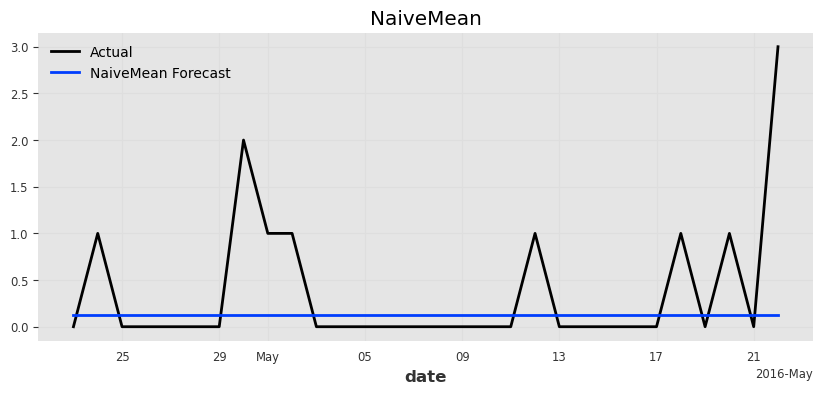

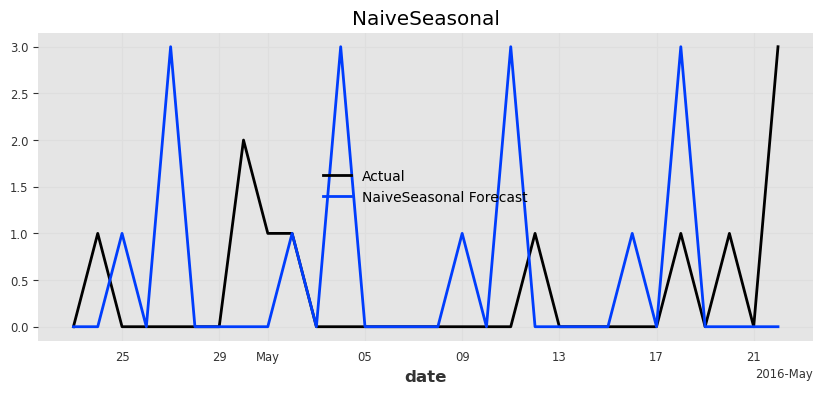

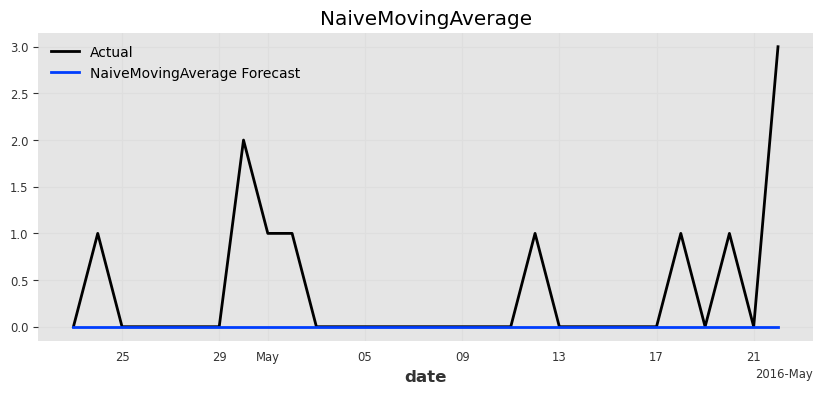

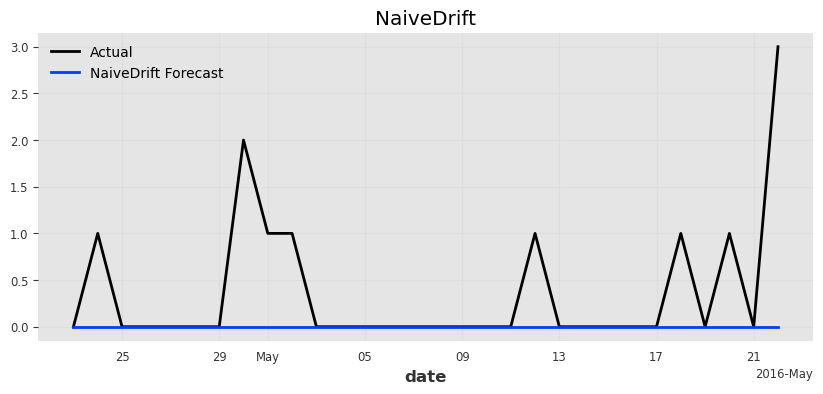

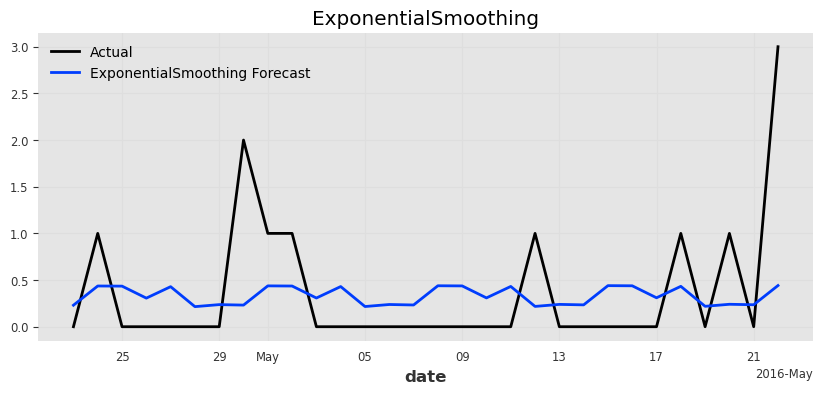

In [32]:
# Run the pipeline
models = get_simple_darts_models()
results = evaluate_models(models, train, val)
forecasts = add_forecasts_to_df(evaluation_df, results)
results_df = results_to_df(results)
metrics_df = add_results_to_metrics_df(evaluation_df, metrics_df, results_df)
metrics_df = append_training_time_to_metrics_df(metrics_df, metrics_df)
metrics_df
# print(results_df)
# Plot the forecasts
plot_forecasts(train, val, results)

In [33]:
evaluation_df

,date,Demand,Naive,NaiveMean,NaiveSeasonal,NaiveMovingAverage,NaiveDrift,ExponentialSmoothing
1911,2016-04-23,0,0.0,0.12,0.0,0.0,0.0,0.23
1912,2016-04-24,1,0.0,0.12,0.0,0.0,0.0,0.44
1913,2016-04-25,0,0.0,0.12,1.0,0.0,0.0,0.43
1914,2016-04-26,0,0.0,0.12,0.0,0.0,0.0,0.31
1915,2016-04-27,0,0.0,0.12,3.0,0.0,0.0,0.43
1916,2016-04-28,0,0.0,0.12,0.0,0.0,0.0,0.22
1917,2016-04-29,0,0.0,0.12,0.0,0.0,0.0,0.24
1918,2016-04-30,2,0.0,0.12,0.0,0.0,0.0,0.23
1919,2016-05-01,1,0.0,0.12,0.0,0.0,0.0,0.44
1920,2016-05-02,1,0.0,0.12,1.0,0.0,0.0,0.44


In [34]:
# export the evaluation DataFrame to an Excel file
evaluation_df.to_excel('single_sku_evaluation.xlsx', index=False)

In [35]:
results_df

,Model,MAE,Bias,Training Time (s)
0,NaiveMean,0.422833,-0.120356,0.004640
1,NaiveSeasonal,0.766667,0.000000,0.004806
2,NaiveMovingAverage,0.366667,0.000000,0.000845
3,NaiveDrift,0.366667,0.000000,0.001585
4,ExponentialSmoothing,0.504567,-0.230555,0.180386


In [36]:
metrics_df

,Model,MAE,MSE,RMSE,MAPE,SMAPE,Cumulative Bias,Mean Bias Deviation,Mean Percentage Bias,Cumulative Relative Error,Training Time (s)
0,Naive,0.37,0.63,0.79,26.67,NaN,11.00,0.37,100.0,3000.0,0.002321
1,NaiveMean,0.42,0.56,0.75,903.93,178.88,7.40,0.25,-inf,-inf,0.004640
2,NaiveSeasonal,0.77,1.70,1.30,4026.67,83.07,-5.00,-0.17,NaN,NaN,0.004806
3,NaiveMovingAverage,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.000845
4,NaiveDrift,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.001585
5,ExponentialSmoothing,0.50,0.49,0.70,2361.76,170.90,1.09,0.04,-inf,-inf,0.180386


The next section will utilize statistical methods to create forecasts. These forecasts will then be illustrated and their metrics recorded.

In [37]:
# Define stats models to evaluate
def get_models():
    return {
        "ARIMA": ARIMA()
    }

In [38]:
# Evaluate models
def evaluate_models(get_models, series, val_series, forecast_horizon=30):
    results = []
    models_dict = get_models()
    for name, model in models_dict.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(series)
        forecast = model.predict(forecast_horizon)
        training_time = time.time() - start_time
        model_mae = mae(val_series, forecast)
        model_bias = float((val_series - forecast).sum().values()[0])
        results.append({
            "Model": name,
            "MAE": model_mae,
            "Bias": model_bias,
            "Training Time (s)": training_time,
            "Forecast": forecast
        })
    return results

In [39]:
# Convert results to DataFrame
def results_to_df(results):
    return pd.DataFrame(
        {
            "Model": r["Model"],
            "MAE": r["MAE"],
            "Bias": r["Bias"],
            "Training Time (s)": r["Training Time (s)"]
        } for r in results
    )

In [40]:
# latest try
# append new model metrics to the metrics_df using the evaluation_df columns
def add_results_to_metrics_df(evaluation_df, metrics_df, results_df):
    # Get the prediction columns excluding 'date', 'Demand', and previous models
    # only include the new model not currently in the metrics_df
    all_forecast_columns = [col for col in evaluation_df.columns if col not in ['date', 'Demand']]
    already_recorded_models = metrics_df['Model'].unique()
    new_forecasts = [col for col in all_forecast_columns if col not in already_recorded_models]
    
    # 

    for model_name in new_forecasts:
        y_true = evaluation_df['Demand'].values
        y_pred = evaluation_df[model_name].values
        epsilon = 0.01
        y_true_safe = np.where(y_true == 0, epsilon, y_true)

        new_row = {
            'Model': model_name,
            'MAE': round(np.mean(np.abs(y_true - y_pred)), 2),
            'MSE': round(np.mean((y_true - y_pred) ** 2), 2),
            'RMSE': round(np.sqrt(np.mean((y_true - y_pred) ** 2)), 2),
            'MAPE': round(np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100, 2),
            'SMAPE': round(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true_safe) + np.abs(y_pred)) * 2) * 100, 2),
            'Cumulative Bias': round(np.sum(y_true - y_pred), 2),
            'Mean Bias Deviation': round(np.mean(y_true - y_pred), 2),
            'Mean Percentage Bias': round(np.mean((y_true - y_pred) / y_true) * 100, 2),
            'Cumulative Relative Error': round(np.sum(((y_true - y_pred) / y_true) * 100), 2),
            # extract the training time from the results_df if available

            'Training Time (s)': results_df.loc[results_df['Model'] == model_name, 'Training Time (s)'].values[0] if model_name in results_df['Model'].values else np.nan
        }

        metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)

    return metrics_df

In [41]:
results_df

,Model,MAE,Bias,Training Time (s)
0,NaiveMean,0.422833,-0.120356,0.004640
1,NaiveSeasonal,0.766667,0.000000,0.004806
2,NaiveMovingAverage,0.366667,0.000000,0.000845
3,NaiveDrift,0.366667,0.000000,0.001585
4,ExponentialSmoothing,0.504567,-0.230555,0.180386


In [42]:
# Plot forecasts
def plot_forecasts(series, val_series, results):
    for r in results:
        plt.figure(figsize=(10, 4))
        # series.plot(label='Train')
        val_series.plot(label='Actual')
        r["Forecast"].plot(label=f'{r["Model"]} Forecast')
        plt.title(r["Model"])
        plt.legend()
        plt.show()

Training ARIMA...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:27: RuntimeWarning: divide by zero encountered in divide
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:28: RuntimeWarning: divide by zero encountered in divide


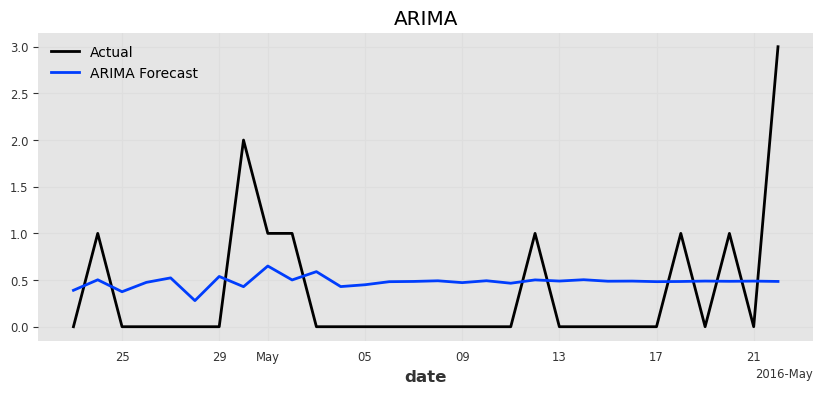

In [43]:
# run the pipeline for the ARIMA model
models = get_models()
results = evaluate_models(get_models, train, val)
forecasts = add_forecasts_to_df(evaluation_df, results)
results_df = results_to_df(results)
metrics_df = add_results_to_metrics_df(evaluation_df, metrics_df, results_df)
# Plot the forecasts
plot_forecasts(train, val, results)
# metrics_df

This next section will run Auto models from DARTS.

In [44]:
metrics_df

,Model,MAE,MSE,RMSE,MAPE,SMAPE,Cumulative Bias,Mean Bias Deviation,Mean Percentage Bias,Cumulative Relative Error,Training Time (s)
0,Naive,0.37,0.63,0.79,26.67,NaN,11.00,0.37,100.0,3000.0,0.002321
1,NaiveMean,0.42,0.56,0.75,903.93,178.88,7.40,0.25,-inf,-inf,0.004640
2,NaiveSeasonal,0.77,1.70,1.30,4026.67,83.07,-5.00,-0.17,NaN,NaN,0.004806
3,NaiveMovingAverage,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.000845
4,NaiveDrift,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.001585
5,ExponentialSmoothing,0.50,0.49,0.70,2361.76,170.90,1.09,0.04,-inf,-inf,0.180386
6,ARIMA,0.58,0.50,0.71,3475.01,165.37,-3.42,-0.11,-inf,-inf,0.553246


In [45]:
# Define auto models to evaluate
def get_models():
    return {
        "AutoARIMA": AutoARIMA(season_length=7),  # Weekly seasonality
        "AutoCES": AutoCES(season_length=7, model="Z"),
        "AutoMFLES": AutoMFLES(season_length=7, test_size=30),
        "AutoTBATS": AutoTBATS(season_length=7),
        "AutoTheta": AutoTheta(season_length=7),
        "Croston": Croston()
    }

Training AutoARIMA...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Training AutoCES...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Training AutoMFLES...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.


Training AutoTBATS...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Training AutoTheta...
Training Croston...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:27: RuntimeWarning: divide by zero encountered in divide
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:28: RuntimeWarning: divide by zero encountered in divide


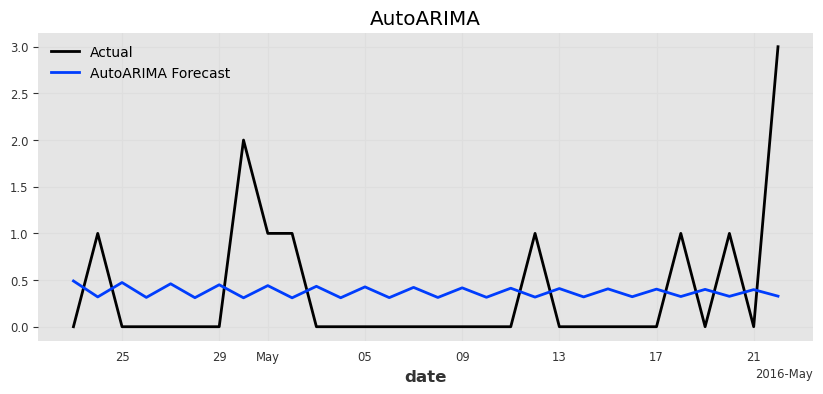

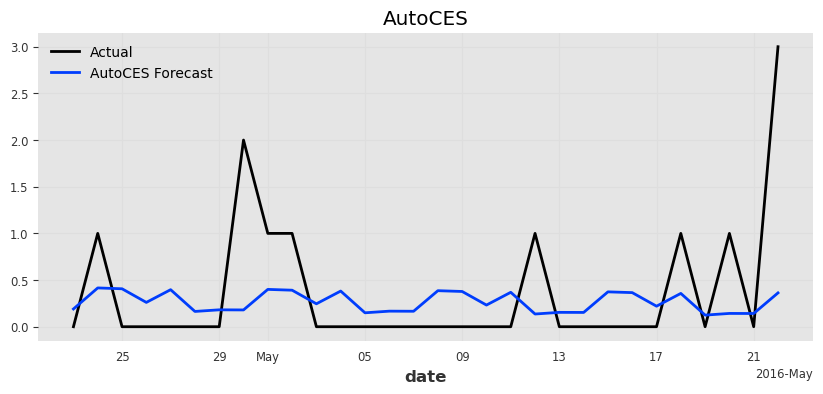

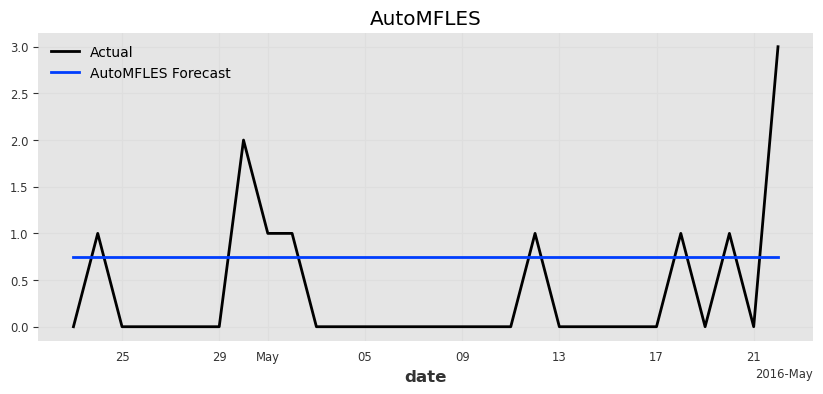

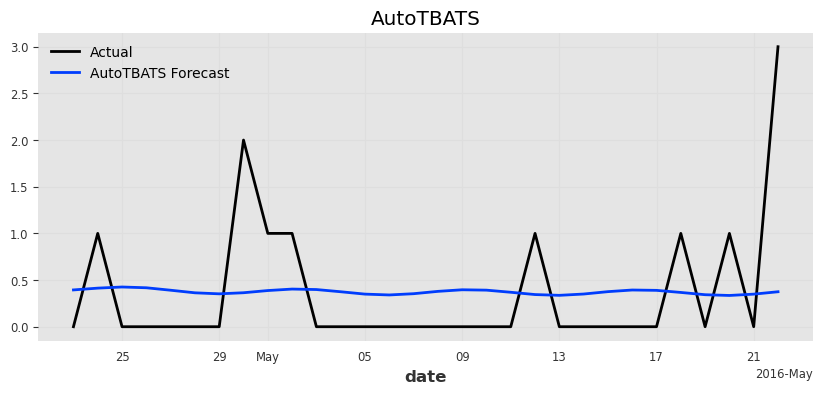

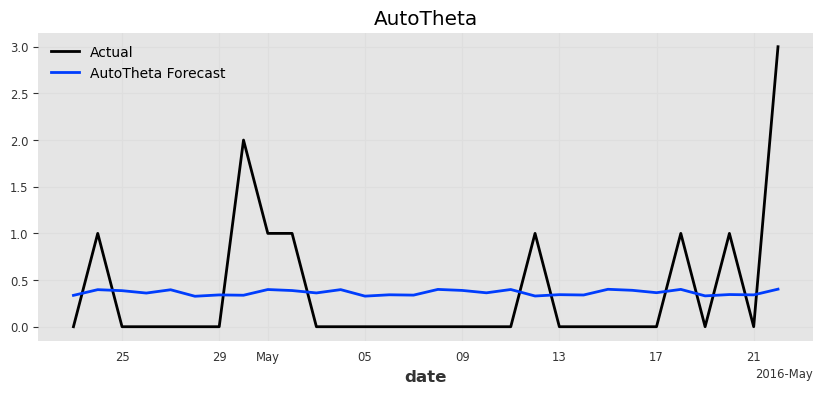

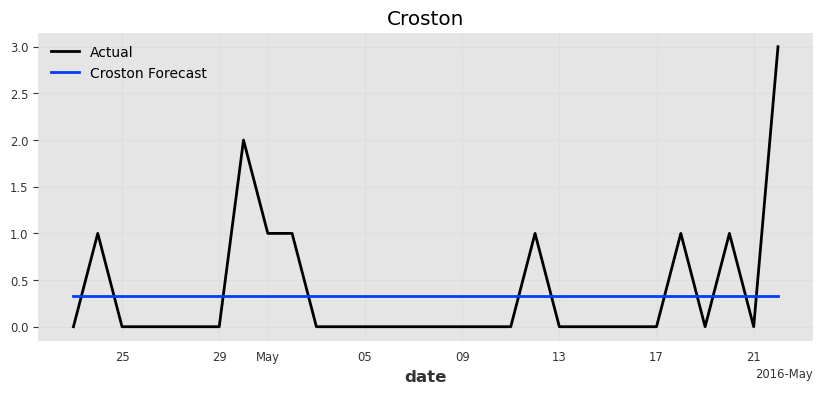

,Model,MAE,MSE,RMSE,MAPE,SMAPE,Cumulative Bias,Mean Bias Deviation,Mean Percentage Bias,Cumulative Relative Error,Training Time (s)
0,Naive,0.37,0.63,0.79,26.67,NaN,11.00,0.37,100.0,3000.0,0.002321
1,NaiveMean,0.42,0.56,0.75,903.93,178.88,7.40,0.25,-inf,-inf,0.004640
2,NaiveSeasonal,0.77,1.70,1.30,4026.67,83.07,-5.00,-0.17,NaN,NaN,0.004806
3,NaiveMovingAverage,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.000845
4,NaiveDrift,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.001585
5,ExponentialSmoothing,0.50,0.49,0.70,2361.76,170.90,1.09,0.04,-inf,-inf,0.180386
6,ARIMA,0.58,0.50,0.71,3475.01,165.37,-3.42,-0.11,-inf,-inf,0.553246
7,AutoARIMA,0.56,0.53,0.73,2855.65,172.87,-0.19,-0.01,-inf,-inf,8.996900
8,AutoCES,0.47,0.50,0.70,1889.80,172.72,3.00,0.10,-inf,-inf,7.682905
9,AutoMFLES,0.72,0.65,0.80,5509.58,157.48,-11.50,-0.38,-inf,-inf,2.836671


In [46]:
# run the pipeline for the Auto models
models = get_models()
results = evaluate_models(get_models, train, val)
forecasts = add_forecasts_to_df(evaluation_df, results)
results_df = results_to_df(results)
metrics_df = add_results_to_metrics_df(evaluation_df, metrics_df, results_df)
# Plot the forecasts
plot_forecasts(train, val, results)
metrics_df

Include complex stats models into the forecasting process.

In [47]:
# Define models to evaluate
def get_models():
    return {
        "KalmanForecaster": KalmanForecaster(dim_x=7),
        "FFT": FFT()
    }

Training KalmanForecaster...
Training FFT...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:27: RuntimeWarning: divide by zero encountered in divide
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:28: RuntimeWarning: divide by zero encountered in divide


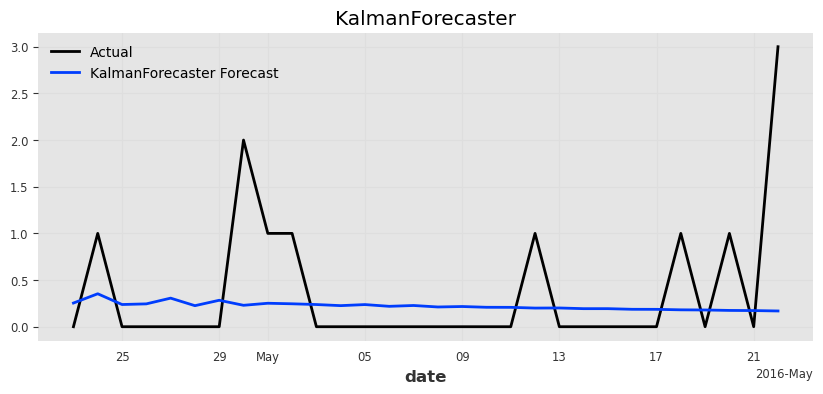

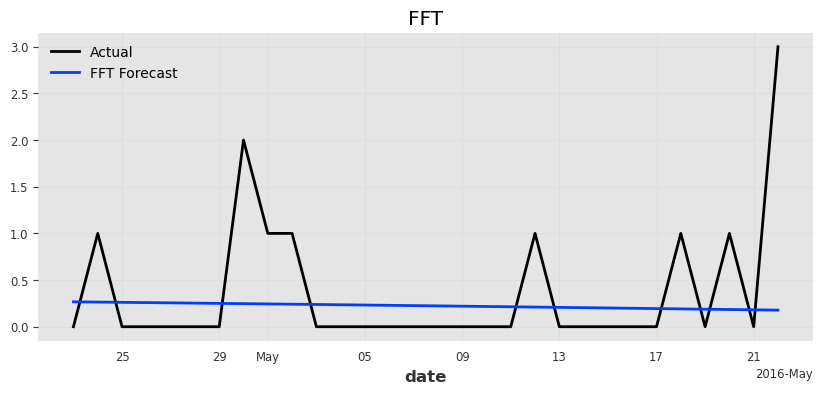

,Model,MAE,MSE,RMSE,MAPE,SMAPE,Cumulative Bias,Mean Bias Deviation,Mean Percentage Bias,Cumulative Relative Error,Training Time (s)
0,Naive,0.37,0.63,0.79,26.67,NaN,11.00,0.37,100.0,3000.0,0.002321
1,NaiveMean,0.42,0.56,0.75,903.93,178.88,7.40,0.25,-inf,-inf,0.004640
2,NaiveSeasonal,0.77,1.70,1.30,4026.67,83.07,-5.00,-0.17,NaN,NaN,0.004806
3,NaiveMovingAverage,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.000845
4,NaiveDrift,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.001585
5,ExponentialSmoothing,0.50,0.49,0.70,2361.76,170.90,1.09,0.04,-inf,-inf,0.180386
6,ARIMA,0.58,0.50,0.71,3475.01,165.37,-3.42,-0.11,-inf,-inf,0.553246
7,AutoARIMA,0.56,0.53,0.73,2855.65,172.87,-0.19,-0.01,-inf,-inf,8.996900
8,AutoCES,0.47,0.50,0.70,1889.80,172.72,3.00,0.10,-inf,-inf,7.682905
9,AutoMFLES,0.72,0.65,0.80,5509.58,157.48,-11.50,-0.38,-inf,-inf,2.836671


In [48]:
# run the pipeline for the complex stats models
models = get_models()
results = evaluate_models(get_models, train, val)
forecasts = add_forecasts_to_df(evaluation_df, results)
results_df = results_to_df(results)
metrics_df = add_results_to_metrics_df(evaluation_df, metrics_df, results_df)
# Plot the forecasts
plot_forecasts(train, val, results)
metrics_df

Implement some machine learning models.

In [49]:
# Define models to evaluate
def get_models():
    return {
        "LightGBM": LightGBMModel(lags=7, output_chunk_length=30),
        "XGBoost": XGBModel(lags=7, output_chunk_length=30),
        "RandomForest": RandomForest(lags=7, output_chunk_length=30),
        "Prophet": Prophet(),
    }

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 1875, number of used features: 7
[LightGBM] [Info] Start training from score 0.118400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
/opt/anaconda3/envs/forceval/lib/python3.11/site-p

Training RandomForest...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
07:17:18 - cmdstanpy - INFO - Chain [1] start processing
07:17:18 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Training Prophet...


/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:27: RuntimeWarning: divide by zero encountered in divide
/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:28: RuntimeWarning: divide by zero encountered in divide
/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce


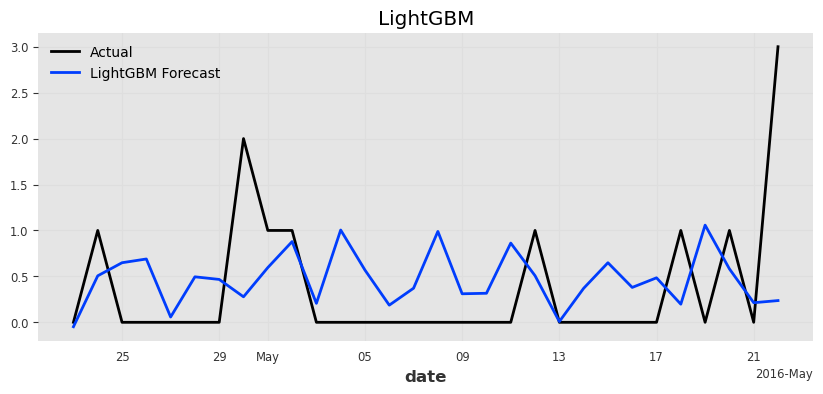

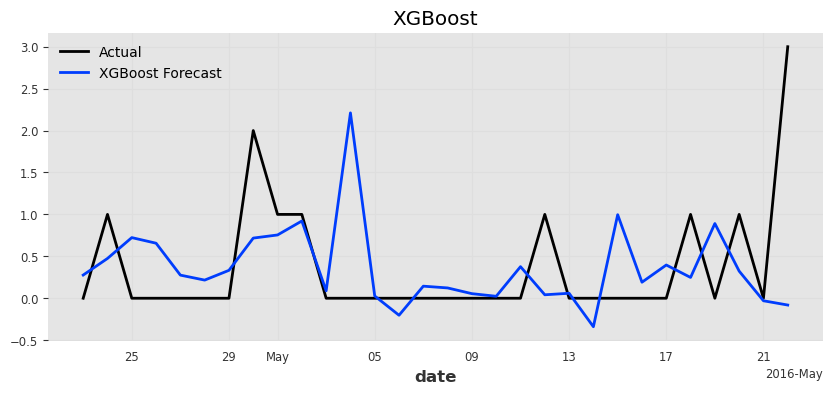

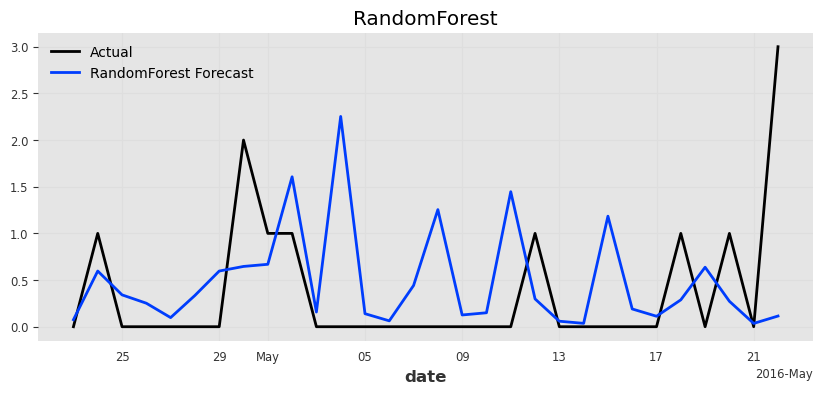

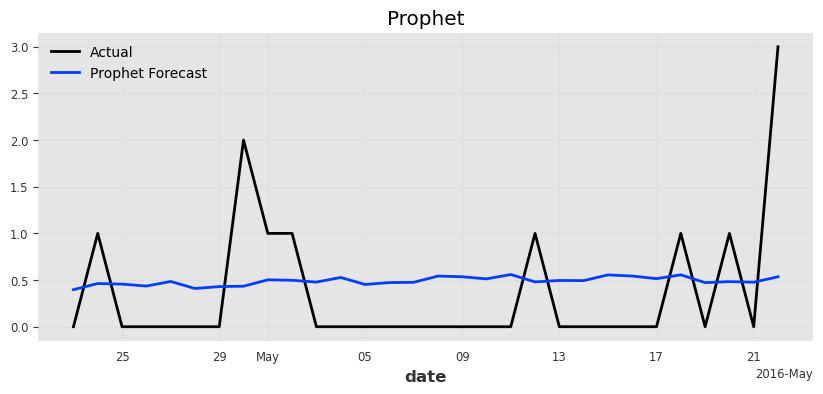

,Model,MAE,MSE,RMSE,MAPE,SMAPE,Cumulative Bias,Mean Bias Deviation,Mean Percentage Bias,Cumulative Relative Error,Training Time (s)
0,Naive,0.37,0.63,0.79,26.67,NaN,11.00,0.37,100.0,3000.0,0.002321
1,NaiveMean,0.42,0.56,0.75,903.93,178.88,7.40,0.25,-inf,-inf,0.004640
2,NaiveSeasonal,0.77,1.70,1.30,4026.67,83.07,-5.00,-0.17,NaN,NaN,0.004806
3,NaiveMovingAverage,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.000845
4,NaiveDrift,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.001585
5,ExponentialSmoothing,0.50,0.49,0.70,2361.76,170.90,1.09,0.04,-inf,-inf,0.180386
6,ARIMA,0.58,0.50,0.71,3475.01,165.37,-3.42,-0.11,-inf,-inf,0.553246
7,AutoARIMA,0.56,0.53,0.73,2855.65,172.87,-0.19,-0.01,-inf,-inf,8.996900
8,AutoCES,0.47,0.50,0.70,1889.80,172.72,3.00,0.10,-inf,-inf,7.682905
9,AutoMFLES,0.72,0.65,0.80,5509.58,157.48,-11.50,-0.38,-inf,-inf,2.836671


In [50]:
# run the pipeline for the Machine Learning models
models = get_models()
results = evaluate_models(get_models, train, val)
forecasts = add_forecasts_to_df(evaluation_df, results)
results_df = results_to_df(results)
metrics_df = add_results_to_metrics_df(evaluation_df, metrics_df, results_df)
# Plot the forecasts
plot_forecasts(train, val, results)
metrics_df

Incorporate Deep Learning Forecasting Models and evaluate them.

In [51]:
train = train.astype(np.float32)
val = val.astype(np.float32)

In [52]:
# Define models to evaluate
def get_models():
    return {
        "RNNModel": RNNModel(input_chunk_length=24, output_chunk_length=24, n_epochs=10),
        "TCNModel": TCNModel(input_chunk_length=24, output_chunk_length=7, n_epochs=10),
        "TransformerModel": TransformerModel(input_chunk_length=24, output_chunk_length=24, n_epochs=10),
        "NBEATSModel": NBEATSModel(input_chunk_length=24, output_chunk_length=24, n_epochs=10),
        # "TFTModel": TFTModel(input_chunk_length=24, output_chunk_length=24, n_epochs=10)
    }

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | RNN              | 700    | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB

Training RNNModel...


/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/1547885689.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 152    | train
-------------------------------------------------------------
152       Trainable params
0         Non-trainable params
152   

Training TCNModel...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 128    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Tran

Training TransformerModel...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.796    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training NBEATSModel...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:27: RuntimeWarning: divide by zero encountered in divide
/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/4271482417.py:28: RuntimeWarning: divide by zero encountered in divide
/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
/opt/anaconda3/envs/forceval/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce


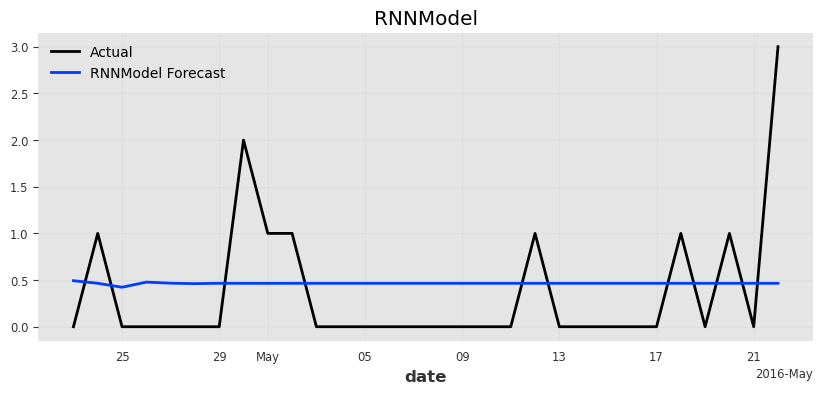

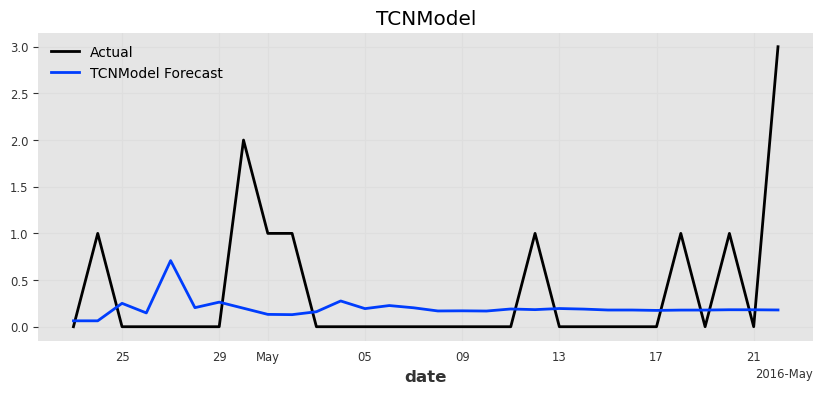

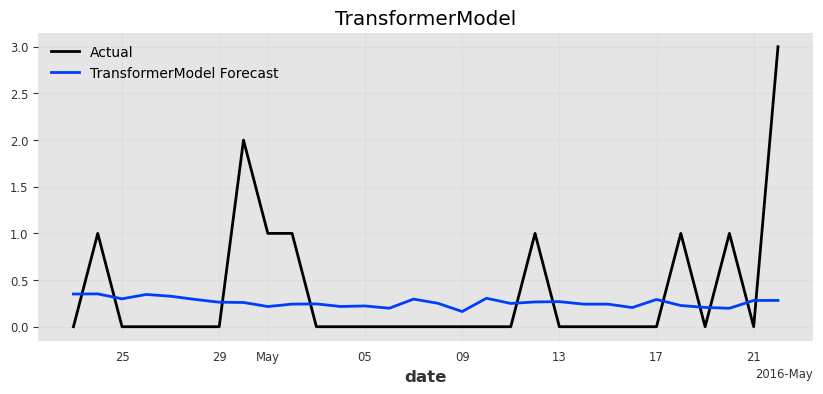

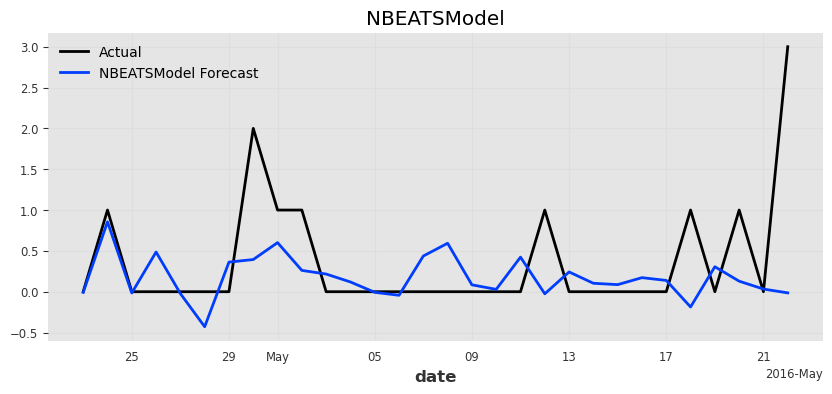

,Model,MAE,MSE,RMSE,MAPE,SMAPE,Cumulative Bias,Mean Bias Deviation,Mean Percentage Bias,Cumulative Relative Error,Training Time (s)
0,Naive,0.37,0.63,0.79,26.67,NaN,11.00,0.37,100.0,3000.0,0.002321
1,NaiveMean,0.42,0.56,0.75,903.93,178.88,7.40,0.25,-inf,-inf,0.004640
2,NaiveSeasonal,0.77,1.70,1.30,4026.67,83.07,-5.00,-0.17,NaN,NaN,0.004806
3,NaiveMovingAverage,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.000845
4,NaiveDrift,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.001585
5,ExponentialSmoothing,0.50,0.49,0.70,2361.76,170.90,1.09,0.04,-inf,-inf,0.180386
6,ARIMA,0.58,0.50,0.71,3475.01,165.37,-3.42,-0.11,-inf,-inf,0.553246
7,AutoARIMA,0.56,0.53,0.73,2855.65,172.87,-0.19,-0.01,-inf,-inf,8.996900
8,AutoCES,0.47,0.50,0.70,1889.80,172.72,3.00,0.10,-inf,-inf,7.682905
9,AutoMFLES,0.72,0.65,0.80,5509.58,157.48,-11.50,-0.38,-inf,-inf,2.836671


In [53]:
# run the pipeline for the Deep Learning models
models = get_models()
results = evaluate_models(get_models, train, val)
forecasts = add_forecasts_to_df(evaluation_df, results)
results_df = results_to_df(results)
metrics_df = add_results_to_metrics_df(evaluation_df, metrics_df, results_df)
# Plot the forecasts
plot_forecasts(train, val, results)
metrics_df

In [54]:
# export the evaluation DataFrame to an Excel file
evaluation_df.to_excel('single_sku_evaluation.xlsx', index=False)
# export the metrics DataFrame to an Excel file
metrics_df.to_excel('single_sku_metrics.xlsx', index=False)

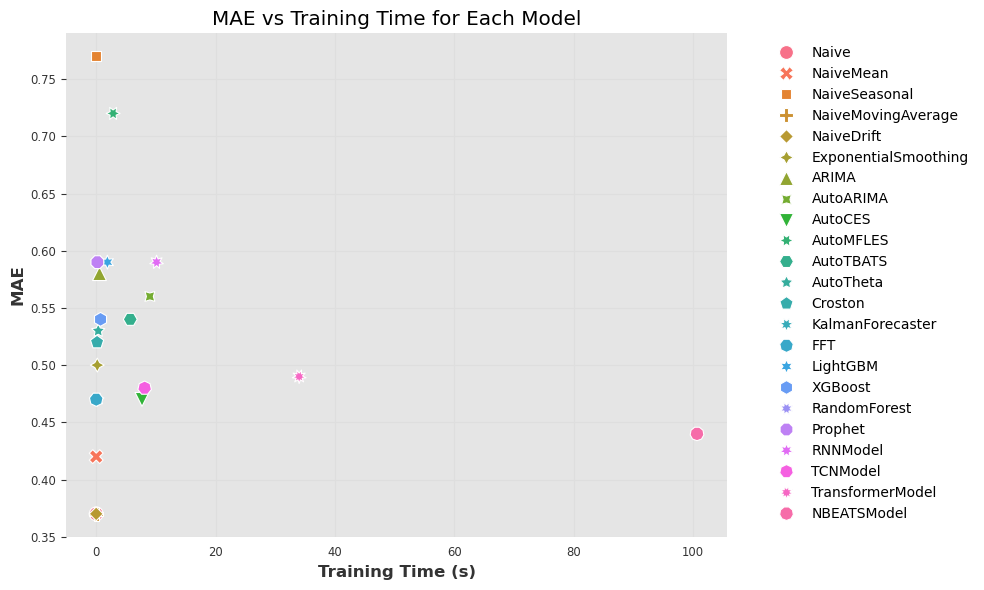

In [55]:
# build a scatterplot of the MAE vs the Training Time for each model
# select only those models that have an MAE less than 8
metrics_df_filtered = metrics_df[metrics_df['MAE'] < 8]


plt.figure(figsize=(10, 6))
sns.scatterplot(data=metrics_df_filtered, x='Training Time (s)', y='MAE', hue='Model', style='Model', s=100)
plt.title('MAE vs Training Time for Each Model')
plt.xlabel('Training Time (s)')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('mae_vs_training_time.png', dpi=300)

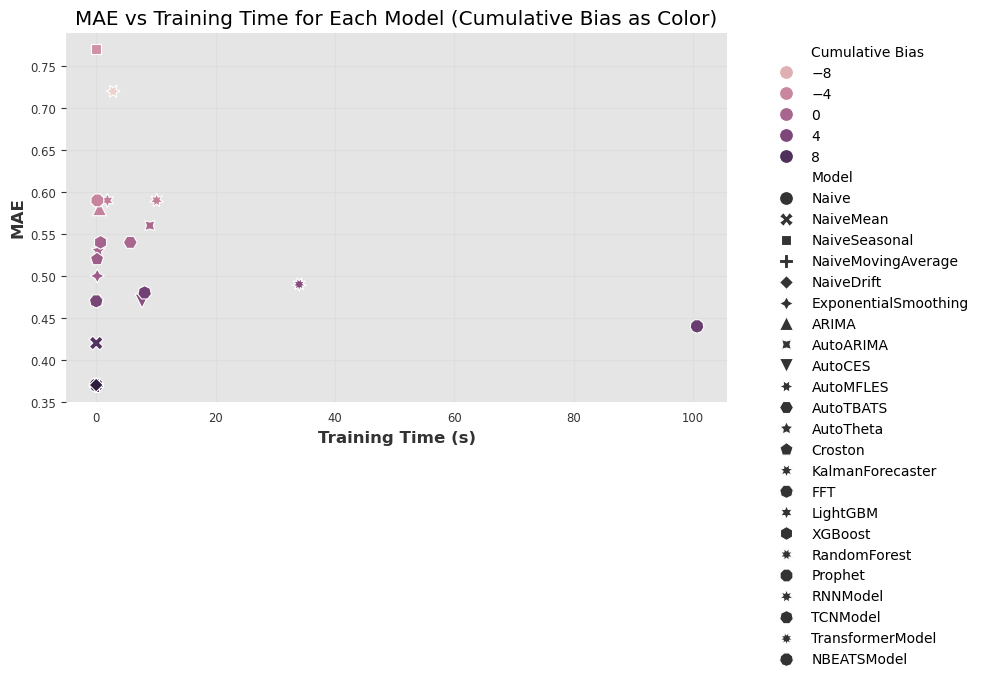

In [56]:
# recreate that plot, but this time, use the cumulative bias as a third dimension
plt.figure(figsize=(10, 6))
sns.scatterplot(data=metrics_df_filtered, x='Training Time (s)', y='MAE', hue='Cumulative Bias', style='Model', s=100)
plt.title('MAE vs Training Time for Each Model (Cumulative Bias as Color)')
plt.xlabel('Training Time (s)')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('mae_vs_training_time_cumulative_bias.png', dpi=300)

/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/2403602877.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/2403602877.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/var/folders/yc/hpm6jjjn4x14df42ls5kh6zh0000gn/T/ipykernel_29122/2403602877.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



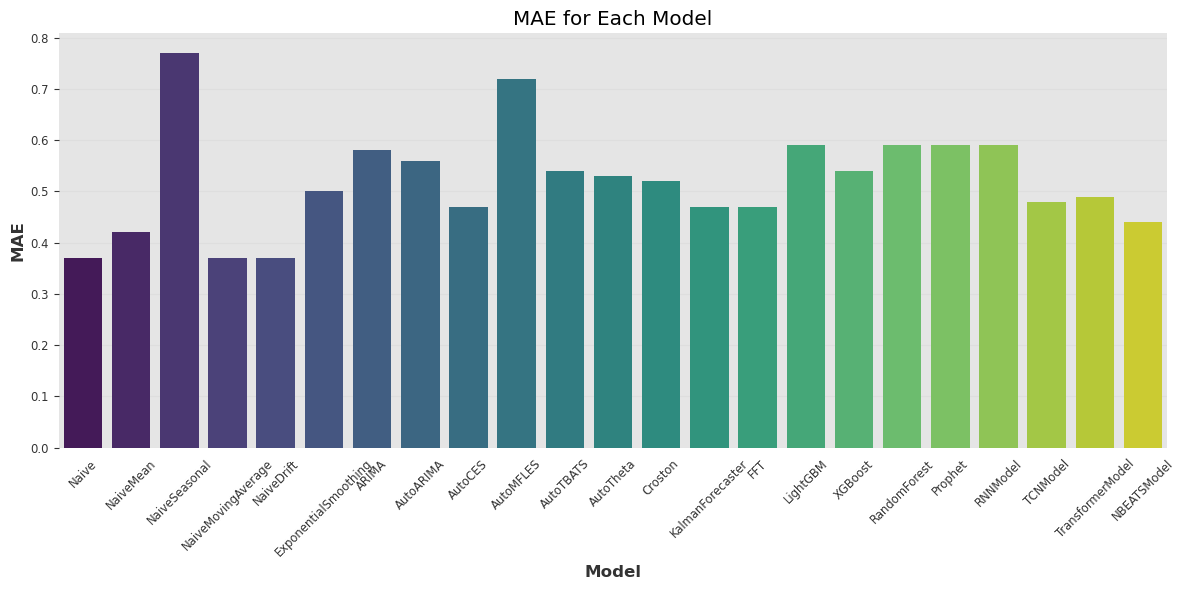

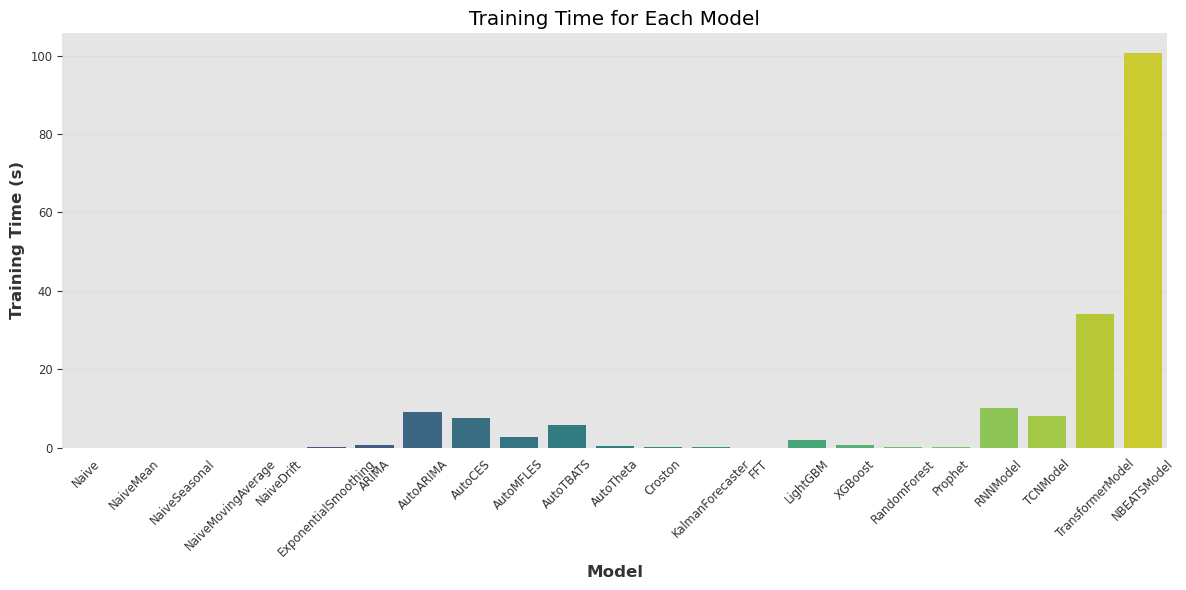

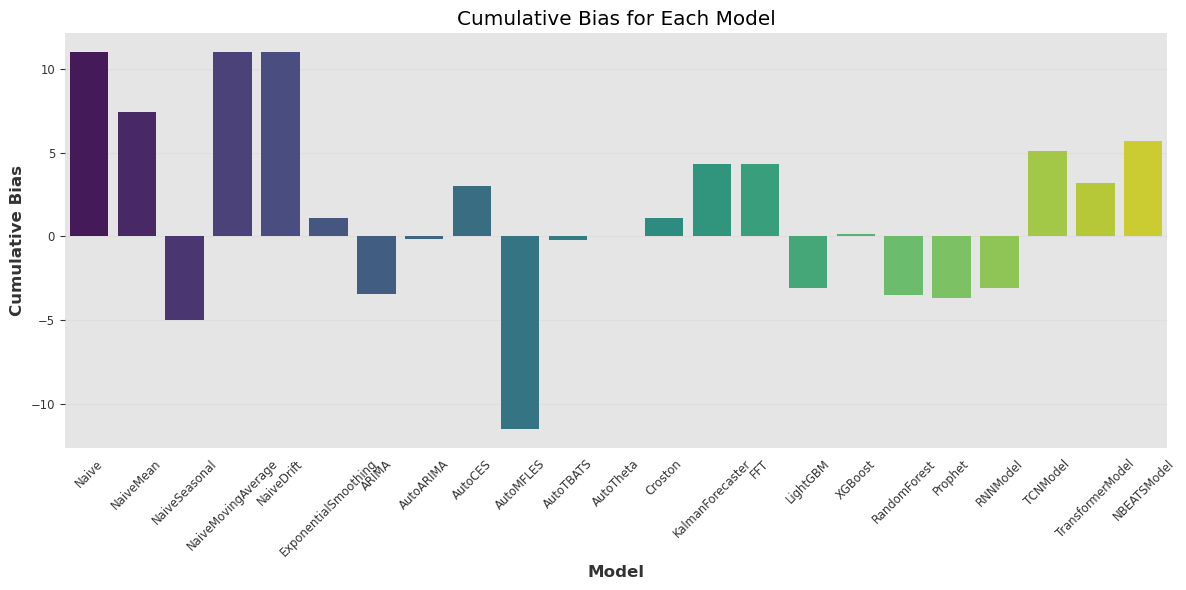

In [57]:
# create a bar plot of the MAE for each model
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df_filtered, x='Model', y='MAE', palette='viridis')
plt.title('MAE for Each Model')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('mae_per_model.png', dpi=300)
# create a bar plot of the Training Time for each model
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df_filtered, x='Model', y='Training Time (s)', palette='viridis')
plt.title('Training Time for Each Model')
plt.xlabel('Model')
plt.ylabel('Training Time (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('training_time_per_model.png', dpi=300)
# create a bar plot of the Cumulative Bias for each model
plt.figure(figsize=(12, 6)) 
sns.barplot(data=metrics_df_filtered, x='Model', y='Cumulative Bias', palette='viridis')
plt.title('Cumulative Bias for Each Model')
plt.xlabel('Model')
plt.ylabel('Cumulative Bias')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('cumulative_bias_per_model.png', dpi=300)

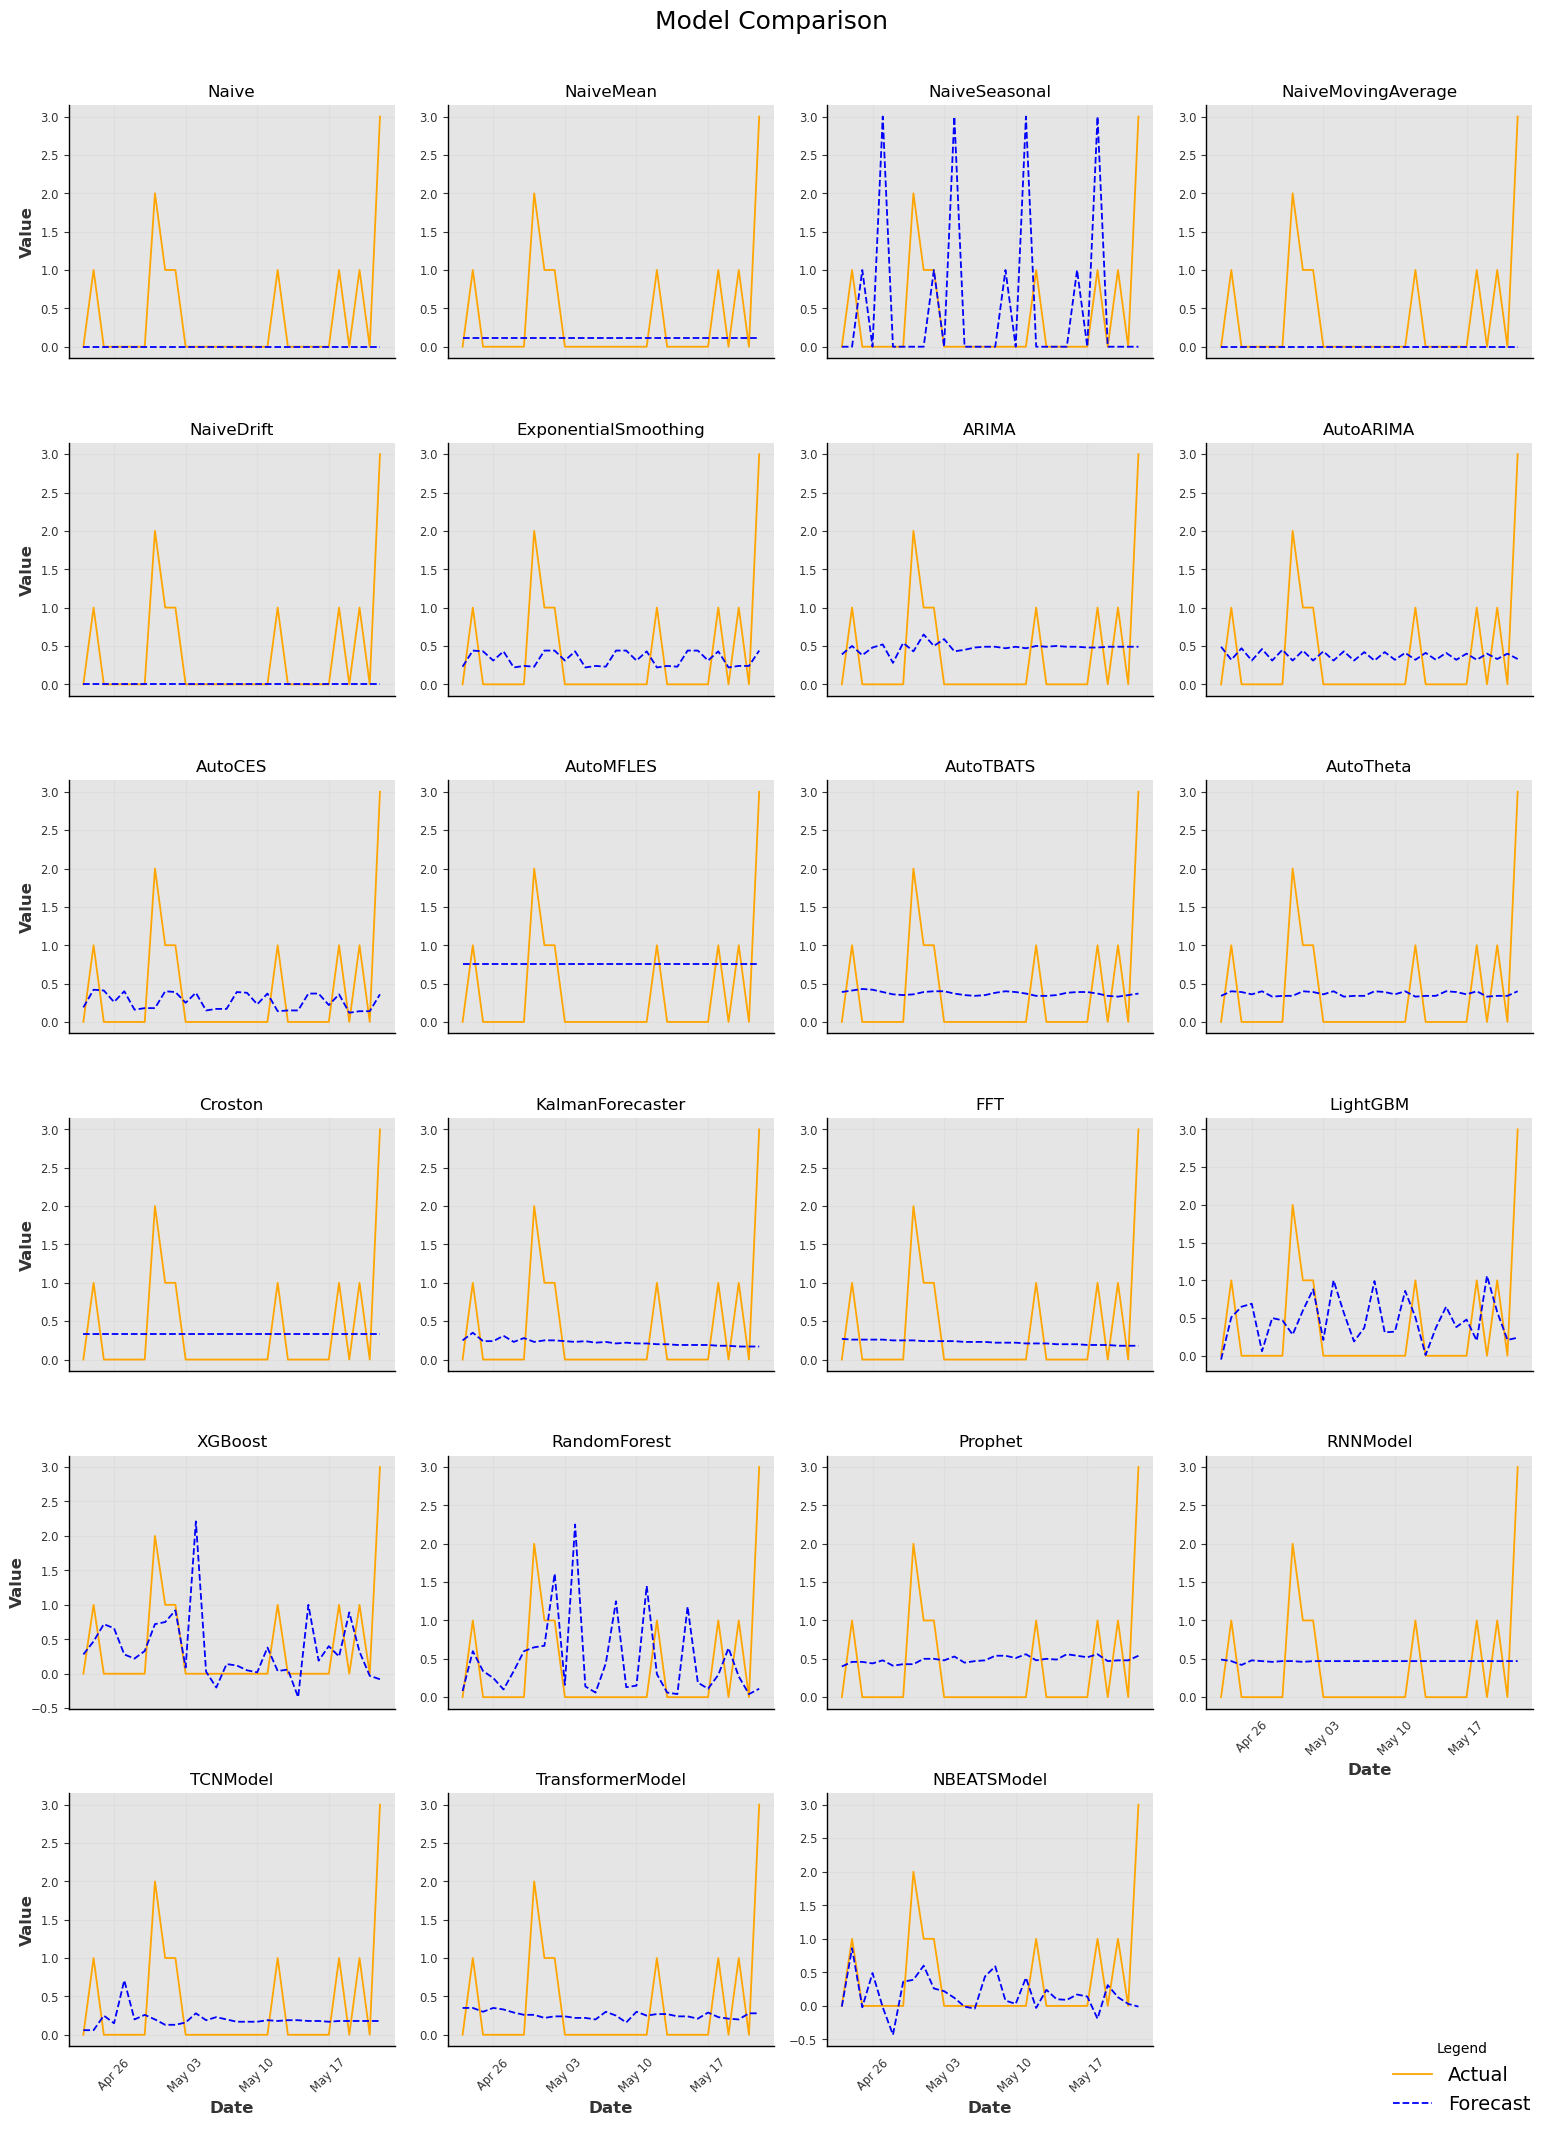

In [58]:
# Assume evaluation_df is already defined and contains your forecast data
# Melt the dataframe into long format
df_melted = evaluation_df.melt(id_vars=["date", "Demand"], var_name="Model", value_name="Forecast")

# Create the facet grid
g = sns.FacetGrid(df_melted, col="Model", col_wrap=4, height=3.5, sharey=False)

# Plot actual and forecast values
g.map_dataframe(sns.lineplot, x="date", y="Demand", color="orange", label="Actual")
g.map_dataframe(sns.lineplot, x="date", y="Forecast", color="blue", linestyle="--", label="Forecast")

# Axis and title settings
g.set_axis_labels("Date", "Value")
g.set_titles(col_template="{col_name}")
g.figure.suptitle("Model Comparison", fontsize=18, y=1.01)
# add a line after the title so that it does not overlap with the plots
# plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
# g.figure.subplots_adjust(top=0.92)

# Improve x-axis formatting: show one date per week
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Add legend
# place legend on lower right corner of the plot
g.add_legend(title="Legend", fontsize=14, loc='lower right')


# Final layout adjustments
plt.tight_layout()
plt.show()

In [59]:
metrics_df

,Model,MAE,MSE,RMSE,MAPE,SMAPE,Cumulative Bias,Mean Bias Deviation,Mean Percentage Bias,Cumulative Relative Error,Training Time (s)
0,Naive,0.37,0.63,0.79,26.67,NaN,11.00,0.37,100.0,3000.0,0.002321
1,NaiveMean,0.42,0.56,0.75,903.93,178.88,7.40,0.25,-inf,-inf,0.004640
2,NaiveSeasonal,0.77,1.70,1.30,4026.67,83.07,-5.00,-0.17,NaN,NaN,0.004806
3,NaiveMovingAverage,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.000845
4,NaiveDrift,0.37,0.63,0.80,26.67,53.33,11.00,0.37,NaN,NaN,0.001585
5,ExponentialSmoothing,0.50,0.49,0.70,2361.76,170.90,1.09,0.04,-inf,-inf,0.180386
6,ARIMA,0.58,0.50,0.71,3475.01,165.37,-3.42,-0.11,-inf,-inf,0.553246
7,AutoARIMA,0.56,0.53,0.73,2855.65,172.87,-0.19,-0.01,-inf,-inf,8.996900
8,AutoCES,0.47,0.50,0.70,1889.80,172.72,3.00,0.10,-inf,-inf,7.682905
9,AutoMFLES,0.72,0.65,0.80,5509.58,157.48,-11.50,-0.38,-inf,-inf,2.836671
